In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
random_state = 0

# IMPORT DATASET

In [4]:
dataset_path = parentdir + "/datasets/EpilepticSeizureRecognition/"

In [5]:
dataset_name = "EpilepticSeizureRecognition"

In [6]:
X = pd.read_csv(dataset_path + "data.csv", index_col = 0)
y = np.array(X["y"])
y_all = np.ravel(y).astype("int")
for i in range(2,6):
    y_all[y_all == i] = 2
le = LabelEncoder()
le.fit(y_all)
y_all = le.transform(y_all)
X_all = X.drop("y", axis = 1).values

In [7]:
from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
rus = RandomUnderSampler(random_state=random_state, )
X_all, y_all = rus.fit_resample(X_all, y_all)

X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

Using TensorFlow backend.
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/frances

In [8]:
print("X SHAPE: ", X_all.shape)
print("y SHAPE: ", y_all.shape)
unique, counts = np.unique(y_all, return_counts=True)
print("\nCLASSES BALANCE")
for i, label in enumerate(unique):
    print(label, ": ", round(counts[i]/sum(counts), 2))

X SHAPE:  (4600, 178, 1)
y SHAPE:  (4600,)

CLASSES BALANCE
0 :  0.5
1 :  0.5


## DATASET SPLIT

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# BLACKBOX TRAIN/TEST SETS SPLIT
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                  test_size=0.2, stratify = y_all, random_state=random_state)

# BLACKBOX/EXPLANATION SETS SPLIT
X_train, X_exp, y_train, y_exp = train_test_split(X_train, y_train, 
                                                  test_size=0.3, stratify = y_train, random_state=random_state)

# BLACKBOX TRAIN/VALIDATION SETS SPLIT
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, stratify = y_train, random_state=random_state)

# EXPLANATION TRAIN/TEST SETS SPLIT
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y_exp, 
                                                                    test_size=0.2, 
                                                                    stratify = y_exp, 
                                                                    random_state=random_state)

# EXPLANATION TRAIN/VALIDATION SETS SPLIT
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp_train, y_exp_train, 
                                                                  test_size=0.2, 
                                                                  stratify = y_exp_train, 
                                                                  random_state=random_state)

print("SHAPES:")
print("BLACKBOX TRAINING SET: ", X_train.shape)
print("BLACKBOX VALIDATION SET: ", X_val.shape)
print("BLACKBOX TEST SET: ", X_test.shape)
print("EXPLANATION TRAINING SET: ", X_exp_train.shape)
print("EXPLANATION VALIDATION SET: ", X_exp_val.shape)
print("EXPLANATION TEST SET: ", X_exp_test.shape)

SHAPES:
BLACKBOX TRAINING SET:  (2060, 178, 1)
BLACKBOX VALIDATION SET:  (516, 178, 1)
BLACKBOX TEST SET:  (920, 178, 1)
EXPLANATION TRAINING SET:  (706, 178, 1)
EXPLANATION VALIDATION SET:  (177, 178, 1)
EXPLANATION TEST SET:  (221, 178, 1)


In [11]:
n_timesteps, n_outputs, n_features = X_train.shape[1], len(np.unique(y_all)), 1 
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  178
N. LABELS:  2


# BLACKBOX MODEL

In [12]:
import keras
import time

In [13]:
from blackboxes import *

In [14]:
import blackboxes

In [15]:
"""import importlib
importlib.reload(blackboxes)"""

'import importlib\nimportlib.reload(blackboxes)'

## resnet

In [16]:
blackbox = build_resnet(n_timesteps, n_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_resnet_20200105_233014_best_weights_+0.99_.hdf5")

In [18]:
resnet = blackbox

## simple CNN

In [19]:
blackbox = build_simple_CNN(n_timesteps, n_outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
blackbox.load_weights(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_simpleCNN_20200105_225722_best_weights_+0.98_.hdf5")

In [21]:
simplecnn = blackbox

## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [23]:
from joblib import load, dump

In [24]:
knn = load(parentdir + "/blackbox_checkpoints/EpilepticSeizureRecognition_blackbox_knn_20200105_225631.joblib")

# AUTOENCODER TRAINING

In [25]:
# TENSORBOARD
# tensorboard --logdir=/tmp/autoencoder
# http://0.0.0.0:6006
# lsof -i tcp:6006 | grep -v PID | awk '{print $2}' | xargs kill

In [26]:
import autoencoders
from autoencoders import *
"""import importlib
importlib.reload(autoencoders)"""

'import importlib\nimportlib.reload(autoencoders)'

## Standard

In [27]:
params = {'input_shape': (178, 1), 
          'n_blocks': 8, 
          'latent_dim': 30, 
          'encoder_latent_layer_type': 'dense', 
          'encoder_args': {'filters': [2, 4, 8, 16, 32, 64, 128, 256], 
                           'kernel_size': [21, 18, 15, 13, 11, 8, 5, 3], 
                           'padding': 'same', 
                           'activation': 'elu', 
                           'pooling': [1, 1, 1, 1, 1, 1, 1, 1]}}

aut = Autoencoder(**params, verbose = False)
encoder, decoder, autoencoder = aut.build()

In [28]:
autoencoder.load_weights(parentdir + "/autoencoder_checkpoints/EpilepticSeizureRecognition_autoencoder_20200106_111007_best_weights_+14872.8621_.hdf5")

# EXPLANATION

In [29]:
import agnosticlocalexplainer
from agnosticlocalexplainer import *

/Users/francesco/anaconda3/envs/tesi/lib/python3.6/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [30]:
index_to_explain = 4

In [31]:
blackbox = resnet

In [32]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [33]:
blackbox_input_dimensions = 3

In [34]:
agnostic = AgnosticLocalExplainer(blackbox, 
                                  encoder, 
                                  decoder, 
                                  autoencoder,  
                                  X_explanation = X_exp_test, 
                                  y_explanation = y_exp_test, 
                                  index_to_explain = index_to_explain,
                                  blackbox_input_dimensions = blackbox_input_dimensions,
                                  labels = ["seizure", "no_seizure"]
                                 )
agnostic.check_autoencoder_blackbox_consistency()

original class == reconstructed class --->  True
Class:  seizure (0)


In [35]:
agnostic.LOREM_neighborhood_generation(
                          neigh_type = 'geneticp', 
                          categorical_use_prob = True,
                          continuous_fun_estimation = False, 
                          size = 1000, 
                          ocr = 0.1, 
                          multi_label=False,
                          one_vs_rest=False,
                          verbose = True, filter_crules = False,
                          ngen = 10)

calculating feature values
gen	nevals	avg     	min     	max     
0  	500   	0.496654	0.496654	0.496654
1  	435   	0.74685 	0.432424	0.991292
2  	423   	0.935038	0.496654	0.993149
3  	418   	0.949623	0.630676	0.993149
4  	416   	0.954073	0.691899	0.993149
5  	423   	0.954354	0.521269	0.993149
6  	431   	0.956808	0.391635	0.993149
7  	422   	0.958042	0.486981	0.993201
8  	424   	0.957884	0.49882 	0.993149
9  	418   	0.960711	0.455816	0.993238
10 	400   	0.963642	0.481454	0.993201
gen	nevals	avg	min	max
0  	500   	0.5	0.5	0.5
1  	433   	0.486337	0.162911	0.898736
2  	438   	0.483578	0.242349	0.980818
3  	429   	0.483479	0.280369	0.7643  
4  	440   	0.478148	0.309929	0.580996
5  	407   	0.480822	0.299897	0.580996
6  	415   	0.484008	0.286113	0.972222
7  	445   	0.484591	0.24906 	0.972222
8  	429   	0.485171	0.221365	0.972222
9  	422   	0.483421	0.191943	0.972222
10 	439   	0.480304	0.215596	0.9368  
synthetic neighborhood class counts {0: 1040, 1: 53}


In [36]:
agnostic.LOREM_tree_rules_extraction()

learning local decision tree
retrieving explanation


In [37]:
agnostic.build_rules_dataframes()

N.RULES =  1
N.COUNTERFACTUAL =  3
rule: 952 time series
crule0: 1 time series
crule1: 2 time series
crule2: 2 time series


In [38]:
agnostic.rules_check_by_augmentation(num_samples = 1000, remove_bad = True, keep_one_crule = True)

rule generated instances have 0.971 accuracy
crule0 generated instances have 0.012 accuracy
removing crule0... Done!
crule1 generated instances have 0.008 accuracy
removing crule1... Done!
crule2 generated instances have 0.041 accuracy
removing crule2... Done!
keeping best crule...  crule2 re-added
rule: 952 time series
crule2: 2 time series


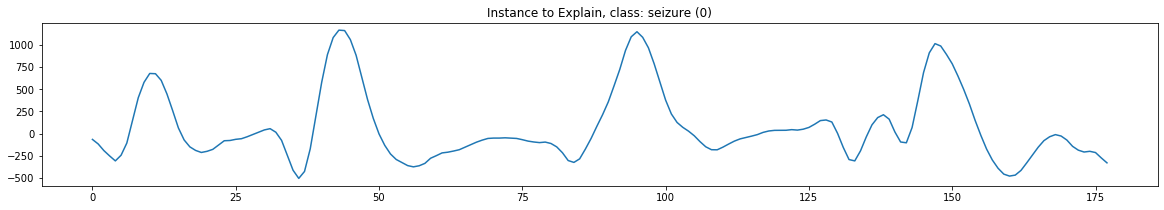

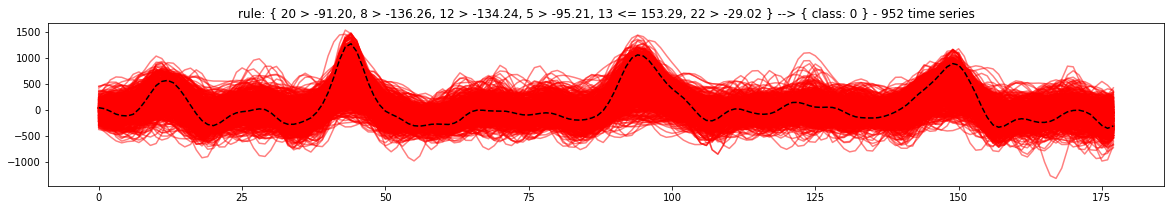

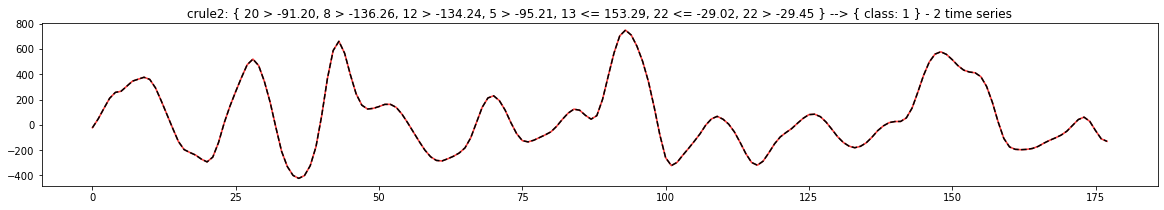

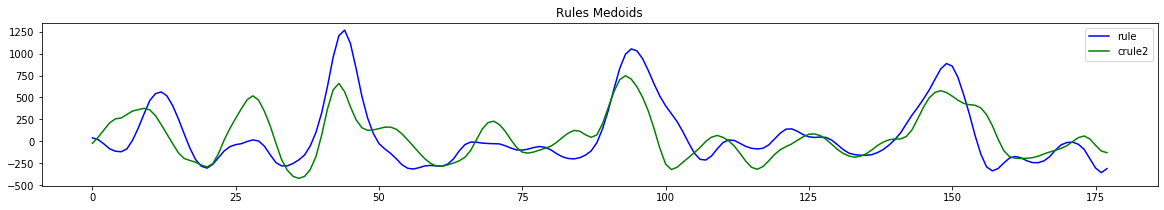

rule


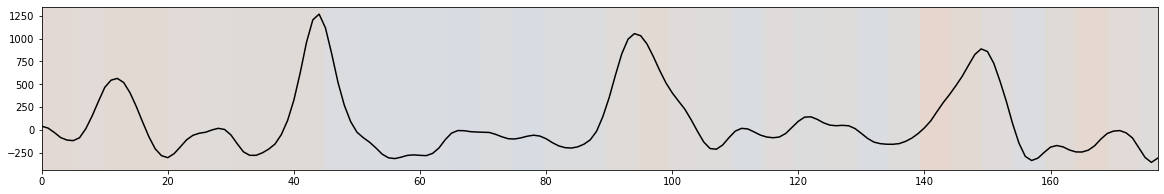

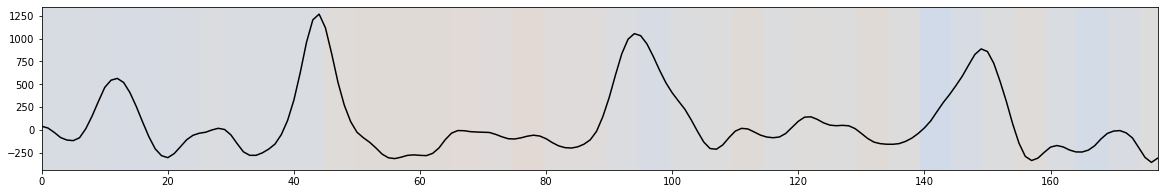

crule2


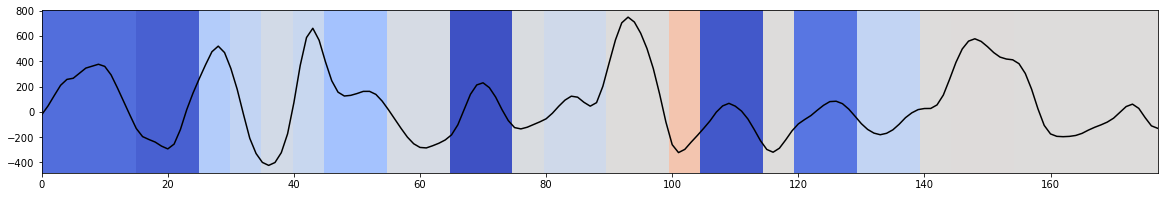

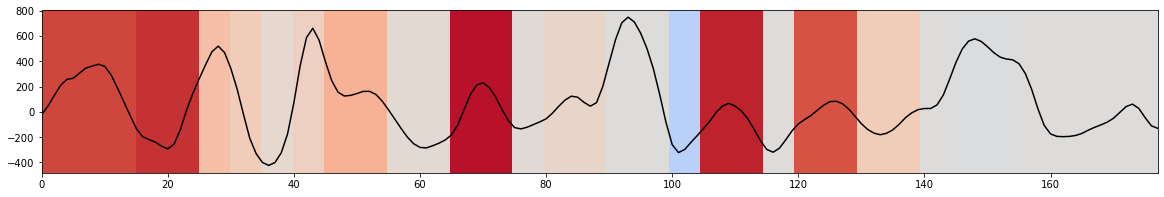

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
rule
TREE PATH
sample predicted class:  seizure
sample real class:  seizure
decision id node 0 : (shapelet n. 7 not-contained)
decision id node 1 : (shapelet n. 3 not-contained)
decision id node 2 : (shapelet n. 0 contained)
decision id node 14 : (shapelet n. 2 not-contained)
decision id node 15 : (shapelet n. 4 not-contained)
decision id node 16 : (shapelet n. 1 not-contained)
decision id node 17 : (shapelet n. 5 not-contained)
decision id node 18 : (shapelet n. 6 not-contained)

VERBOSE EXPLANATION
If shapelet n. 7 is not-contained, and shapelet n. 3 is not-contained, and shapelet n. 0 is contained, and shapelet n. 2 is not-contained, and shapelet n. 4 is not-contained, and shapelet n. 1 is not-contained, and shapelet n. 5 is not-contained, and shapelet n. 6 is not-contained, then the class is seizure

COMPLETE EXPLANATION
If shapelet n. 7 is not-contained

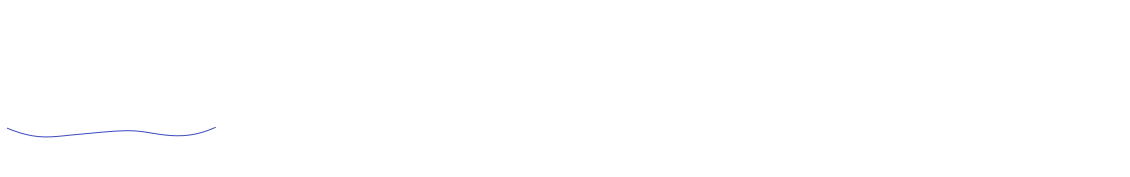

and shapelet n. 3 is not-contained

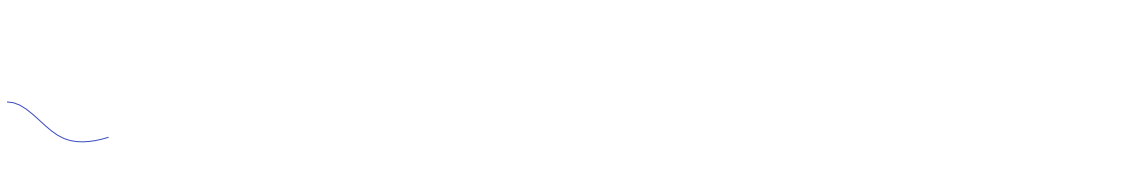

and shapelet n. 0 is contained

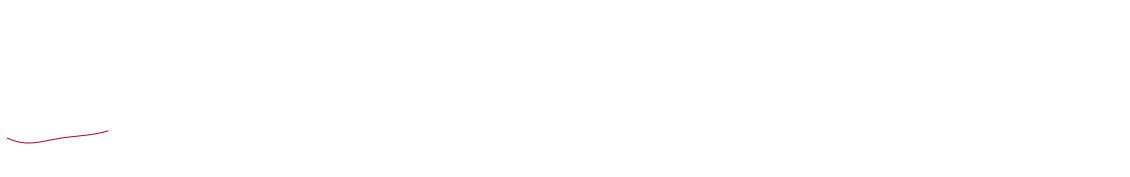

and shapelet n. 2 is not-contained

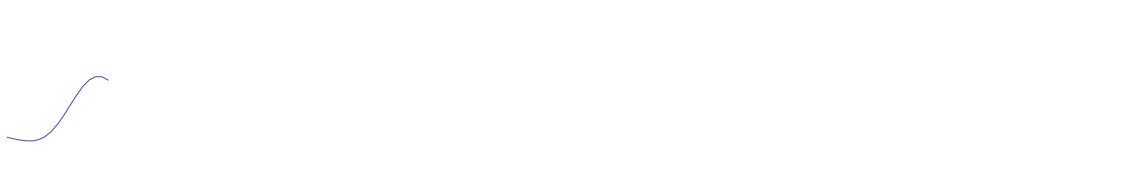

and shapelet n. 4 is not-contained

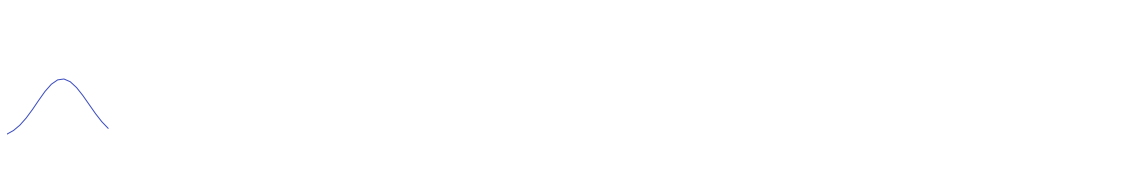

and shapelet n. 1 is not-contained

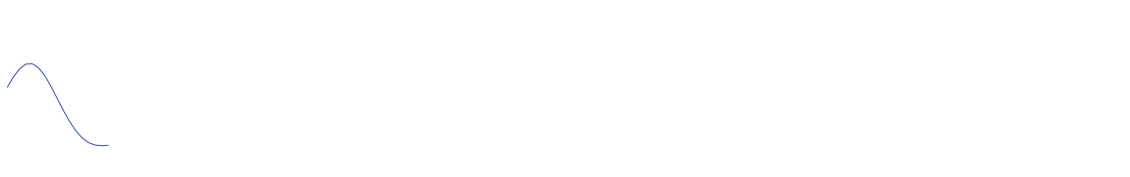

and shapelet n. 5 is not-contained

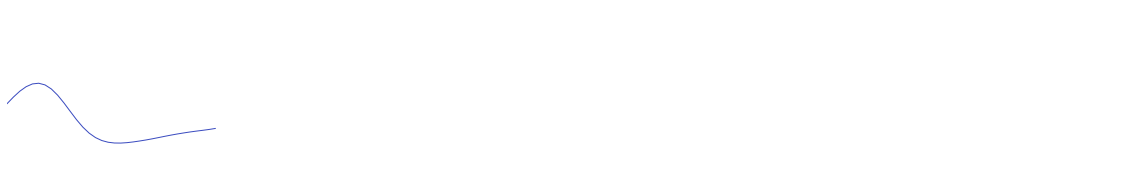

and shapelet n. 6 is not-contained

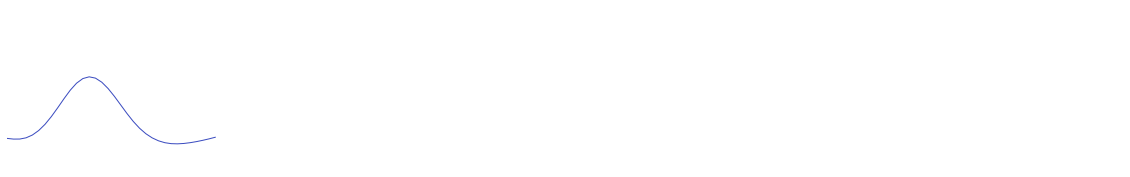

then the class is seizure


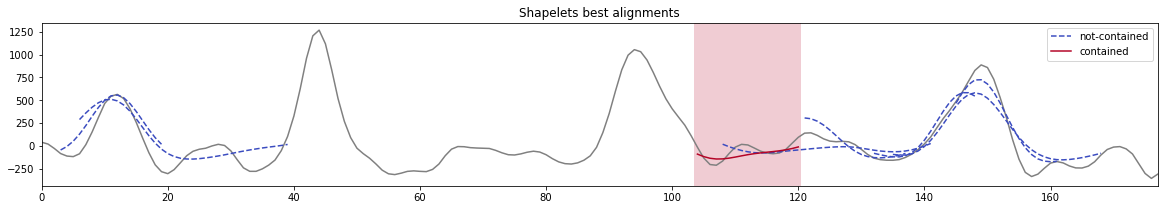

crule2
TREE PATH
sample predicted class:  seizure
sample real class:  no_seizure
decision id node 0 : (shapelet n. 7 not-contained)
decision id node 1 : (shapelet n. 3 not-contained)
decision id node 2 : (shapelet n. 0 contained)
decision id node 14 : (shapelet n. 2 not-contained)
decision id node 15 : (shapelet n. 4 not-contained)
decision id node 16 : (shapelet n. 1 not-contained)
decision id node 17 : (shapelet n. 5 not-contained)
decision id node 18 : (shapelet n. 6 not-contained)

VERBOSE EXPLANATION
If shapelet n. 7 is not-contained, and shapelet n. 3 is not-contained, and shapelet n. 0 is contained, and shapelet n. 2 is not-contained, and shapelet n. 4 is not-contained, and shapelet n. 1 is not-contained, and shapelet n. 5 is not-contained, and shapelet n. 6 is not-contained, then the class is seizure

COMPLETE EXPLANATION
If shapelet n. 7 is not-contained

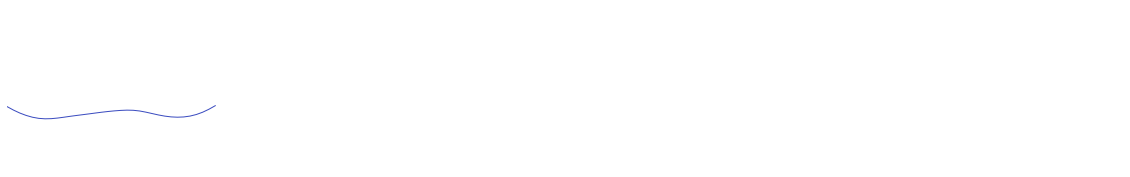

and shapelet n. 3 is not-contained

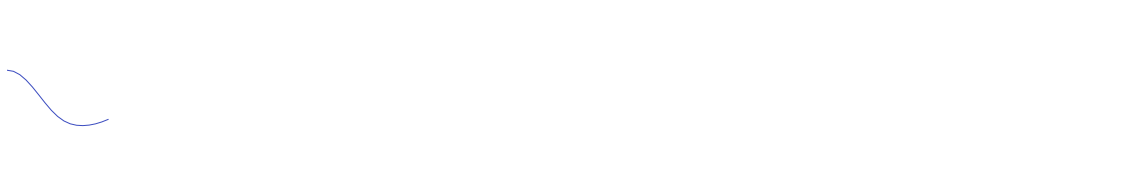

and shapelet n. 0 is contained

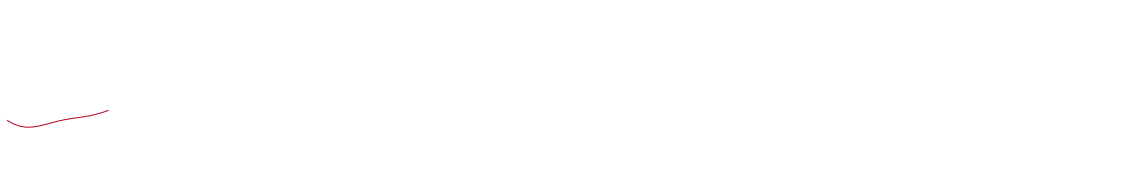

and shapelet n. 2 is not-contained

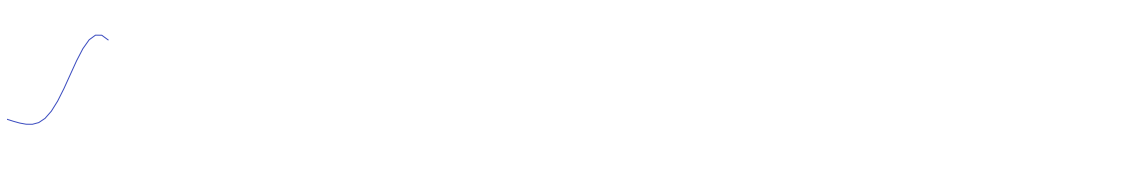

and shapelet n. 4 is not-contained

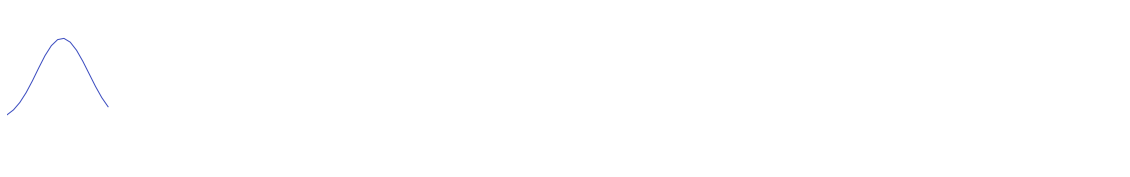

and shapelet n. 1 is not-contained

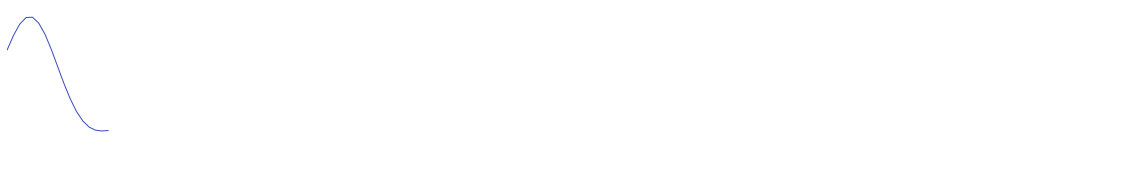

and shapelet n. 5 is not-contained

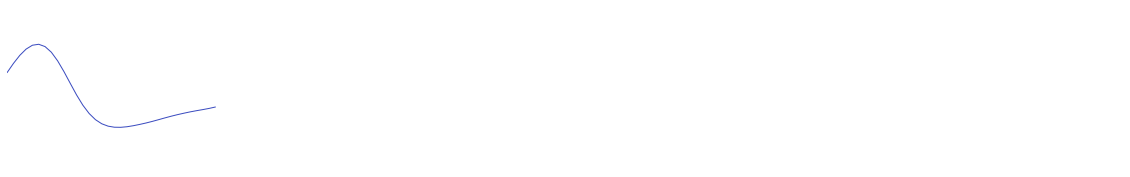

and shapelet n. 6 is not-contained

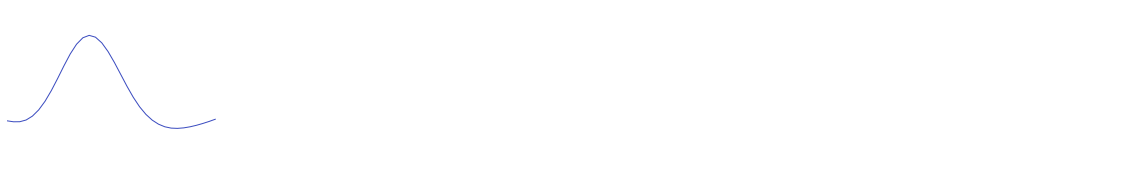

then the class is seizure


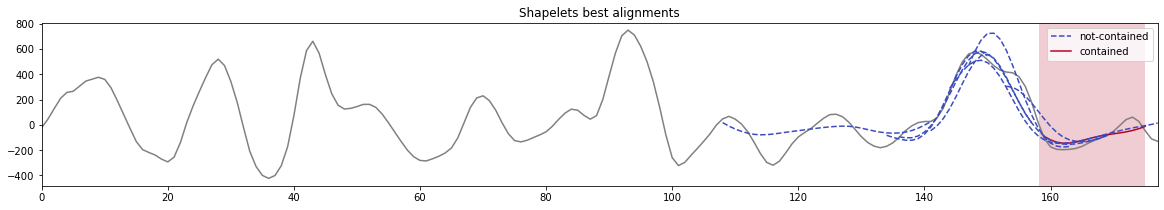

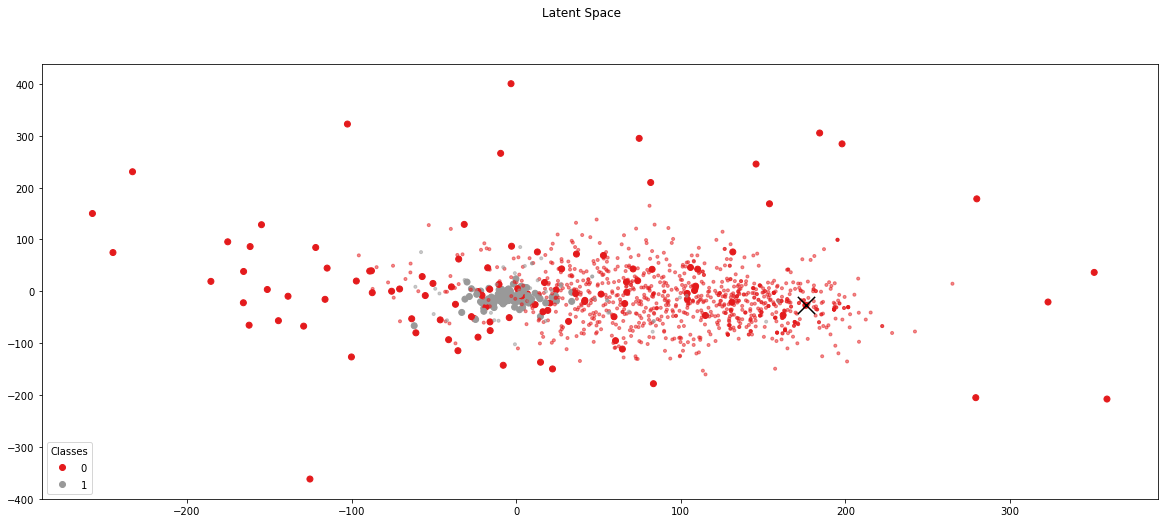

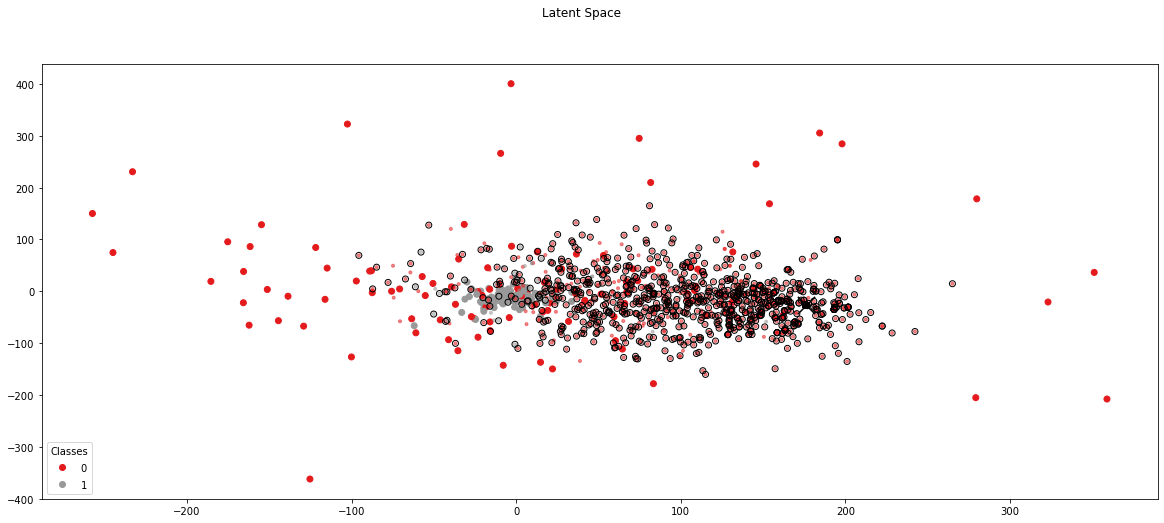

In [40]:
params = {"background": "linear", 
          "rebuild_shapelet_explainer": True,
          "nsamples":500, 
          "shap_by_class" : False,
          "multishap_n":30}
    
agnostic.plot_explanation( 
                     rules = True, 
                     heatmap = False, 
                     shap_explanation = False, 
                     shapelet_explanation = True,
                     latent_space = True,
                     multi_shap_explanation = True,
                     figsize = (20,3),
                     VAE_2d = False,
                     **params
                     )